In [2]:
!pip install numpy==1.26.4


   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   --- ------------------------------------ 1.3/15.8 MB 7.5 MB/s eta 0:00:02
   ------ --------------------------------- 2.6/15.8 MB 6.9 MB/s eta 0:00:02
   --------- ------------------------------ 3.9/15.8 MB 6.7 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/15.8 MB 7.5 MB/s eta 0:00:02
   ------------------- -------------------- 7.9/15.8 MB 8.0 MB/s eta 0:00:01
   ------------------------- -------------- 10.0/15.8 MB 8.4 MB/s eta 0:00:01
   ----------------------------- ---------- 11.5/15.8 MB 8.4 MB/s eta 0:00:01
   --------------------------------- ------ 13.4/15.8 MB 8.4 MB/s eta 0:00:01
   ------------------------------------- -- 14.9/15.8 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 15.8/15.8 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
from nuscenes.nuscenes import NuScenes
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
from heapq import heappop, heappush
from matplotlib import animation
from torch.utils.data import Dataset
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from scipy.spatial import cKDTree
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import heapq
import torch.nn.functional as F

dataroot = r"C:\nuscenes_project\dataset"
version = "v1.0-mini"

nusc = NuScenes(version=version, dataroot=dataroot, verbose=False)

#Getting all pedestrians' annotations
pedestrian_annos = [
    ann for ann in nusc.sample_annotation if ann['category_name'].startswith('human.pedestrian')
]

#unique pedestrians
pedestrian_tokens = list(set([ann['instance_token'] for ann in pedestrian_annos]))

#collecting traj
all_trajectories = []

for token in pedestrian_tokens:
    try:
        first_anno = next(ann for ann in nusc.sample_annotation if ann['instance_token'] == token and ann['prev'] == "")
    except StopIteration:
        continue

    trajectory = []
    sample_token = first_anno['token']
    while sample_token:
        ann = nusc.get('sample_annotation', sample_token)
        x, y = ann['translation'][:2]
        trajectory.append([x, y])
        sample_token = ann['next']

    if len(trajectory) >= 6:
        trajectory = np.array(trajectory)

    #mormalisation
        #trajectory -= trajectory[0]          
        #trajectory = trajectory / 10.0       

        all_trajectories.append({
            "agent_id": token,
            "trajectory": trajectory.tolist()
        })


#saving
output_path = os.path.join(dataroot, "pedestrian_dataset.json")
with open(output_path, "w") as f:
    json.dump(all_trajectories, f, indent=2)

print(f" Saved to: {output_path}")
print(f"Trajectories: {len(all_trajectories)}")


 Saved to: C:\nuscenes_project\dataset\pedestrian_dataset.json
Trajectories: 206


In [2]:
nusc.sample_annotation[0]


{'token': '70aecbe9b64f4722ab3c230391a3beb8',
 'sample_token': 'cd21dbfc3bd749c7b10a5c42562e0c42',
 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5',
 'visibility_token': '4',
 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'],
 'translation': [373.214, 1130.48, 1.25],
 'size': [0.621, 0.669, 1.642],
 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616],
 'prev': 'a1721876c0944cdd92ebc3c75d55d693',
 'next': '1e8e35d365a441a18dd5503a0ee1c208',
 'num_lidar_pts': 5,
 'num_radar_pts': 0,
 'category_name': 'human.pedestrian.adult'}

In [3]:
[cat['name'] for cat in nusc.category]


['human.pedestrian.adult',
 'human.pedestrian.child',
 'human.pedestrian.wheelchair',
 'human.pedestrian.stroller',
 'human.pedestrian.personal_mobility',
 'human.pedestrian.police_officer',
 'human.pedestrian.construction_worker',
 'animal',
 'vehicle.car',
 'vehicle.motorcycle',
 'vehicle.bicycle',
 'vehicle.bus.bendy',
 'vehicle.bus.rigid',
 'vehicle.truck',
 'vehicle.construction',
 'vehicle.emergency.ambulance',
 'vehicle.emergency.police',
 'vehicle.trailer',
 'movable_object.barrier',
 'movable_object.trafficcone',
 'movable_object.pushable_pullable',
 'movable_object.debris',
 'static_object.bicycle_rack']

In [4]:
nusc.sample_annotation[0].keys()


dict_keys(['token', 'sample_token', 'instance_token', 'visibility_token', 'attribute_tokens', 'translation', 'size', 'rotation', 'prev', 'next', 'num_lidar_pts', 'num_radar_pts', 'category_name'])

In [5]:
for ann in nusc.sample_annotation:
    if 'pedestrian' in ann['category_name']:
        print(ann)
        break


{'token': '70aecbe9b64f4722ab3c230391a3beb8', 'sample_token': 'cd21dbfc3bd749c7b10a5c42562e0c42', 'instance_token': '6dd2cbf4c24b4caeb625035869bca7b5', 'visibility_token': '4', 'attribute_tokens': ['4d8821270b4a47e3a8a300cbec48188e'], 'translation': [373.214, 1130.48, 1.25], 'size': [0.621, 0.669, 1.642], 'rotation': [0.9831098797903927, 0.0, 0.0, -0.18301629506281616], 'prev': 'a1721876c0944cdd92ebc3c75d55d693', 'next': '1e8e35d365a441a18dd5503a0ee1c208', 'num_lidar_pts': 5, 'num_radar_pts': 0, 'category_name': 'human.pedestrian.adult'}


In [6]:
#annotations table
pd.DataFrame(nusc.sample_annotation).head()


,token,sample_token,instance_token,visibility_token,attribute_tokens,translation,size,rotation,prev,next,num_lidar_pts,num_radar_pts,category_name
0,70aecbe9b64f4722ab3c230391a3beb8,cd21dbfc3bd749c7b10a5c42562e0c42,6dd2cbf4c24b4caeb625035869bca7b5,4,[4d8821270b4a47e3a8a300cbec48188e],"[373.214, 1130.48, 1.25]","[0.621, 0.669, 1.642]","[0.9831098797903927, 0.0, 0.0, -0.183016295062...",a1721876c0944cdd92ebc3c75d55d693,1e8e35d365a441a18dd5503a0ee1c208,5,0,human.pedestrian.adult
1,7fa3a688931b4500b7ce29d187d3b975,2ff86dc19c4644a1a88ce5ba848f56e5,6dd2cbf4c24b4caeb625035869bca7b5,4,[4d8821270b4a47e3a8a300cbec48188e],"[373.152, 1130.357, 1.25]","[0.621, 0.669, 1.642]","[0.9831098797903927, 0.0, 0.0, -0.183016295062...",1e8e35d365a441a18dd5503a0ee1c208,913072e56d6c4025b9b47ba085dd6d7c,6,0,human.pedestrian.adult
2,93d5b79041c64693a5b32f1103a39a06,29e056fc277543c9bc42310b122c640e,6dd2cbf4c24b4caeb625035869bca7b5,1,[4d8821270b4a47e3a8a300cbec48188e],"[373.35, 1130.67, 1.123]","[0.621, 0.669, 1.642]","[0.9831098797903927, 0.0, 0.0, -0.183016295062...",3b24f083c0bf42d695a1040efdab7ffe,8bb63134d48840aaa2993f490855ff0d,2,0,human.pedestrian.adult
3,ef63a697930c4b20a6b9791f423351da,ca9a282c9e77460f8360f564131a8af5,6dd2cbf4c24b4caeb625035869bca7b5,1,[4d8821270b4a47e3a8a300cbec48188e],"[373.256, 1130.419, 0.8]","[0.621, 0.669, 1.642]","[0.9831098797903927, 0.0, 0.0, -0.183016295062...",,7987617983634b119e383d8a29607fd7,1,0,human.pedestrian.adult
4,7987617983634b119e383d8a29607fd7,39586f9d59004284a7114a68825e8eec,6dd2cbf4c24b4caeb625035869bca7b5,1,[4d8821270b4a47e3a8a300cbec48188e],"[373.256, 1130.419, 0.81]","[0.621, 0.669, 1.642]","[0.9831098797903927, 0.0, 0.0, -0.183016295062...",ef63a697930c4b20a6b9791f423351da,9acb7dfed3454f72b2874dda3bdacc48,1,0,human.pedestrian.adult


In [7]:
#objects categories: pedestrians, vehicles, animals
pd.DataFrame(nusc.category)


,token,name,description
0,1fa93b757fc74fb197cdd60001ad8abf,human.pedestrian.adult,Adult subcategory.
1,b1c6de4c57f14a5383d9f963fbdcb5cb,human.pedestrian.child,Child subcategory.
2,b2d7c6c701254928a9e4d6aac9446d79,human.pedestrian.wheelchair,"Wheelchairs. If a person is in the wheelchair,..."
3,6a5888777ca14867a8aee3fe539b56c4,human.pedestrian.stroller,"Strollers. If a person is in the stroller, inc..."
4,403fede16c88426885dd73366f16c34a,human.pedestrian.personal_mobility,"A small electric or self-propelled vehicle, e...."
5,bb867e2064014279863c71a29b1eb381,human.pedestrian.police_officer,Police officer.
6,909f1237d34a49d6bdd27c2fe4581d79,human.pedestrian.construction_worker,Construction worker
7,63a94dfa99bb47529567cd90d3b58384,animal,"All animals, e.g. cats, rats, dogs, deer, birds."
8,fd69059b62a3469fbaef25340c0eab7f,vehicle.car,"Vehicle designed primarily for personal use, e..."
9,dfd26f200ade4d24b540184e16050022,vehicle.motorcycle,Gasoline or electric powered 2-wheeled vehicle...


In [8]:
#instances (annotations)
pd.DataFrame(nusc.instance).head()


,token,category_token,nbr_annotations,first_annotation_token,last_annotation_token
0,6dd2cbf4c24b4caeb625035869bca7b5,1fa93b757fc74fb197cdd60001ad8abf,39,ef63a697930c4b20a6b9791f423351da,8bb63134d48840aaa2993f490855ff0d
1,48d58b69b40149aeb2e64aa4b1a9192f,1fa93b757fc74fb197cdd60001ad8abf,30,6b89da9bf1f84fd6a5fbe1c3b236f809,2f69a953ed424deaa2a89ff4cd515c51
2,bd26c2cdb22d4bb1834e808c89128898,fd69059b62a3469fbaef25340c0eab7f,37,924ee6ac1fed440a9d9e3720aac635a0,e4f4f8403b744d73b118413da45cd265
3,6e04e175f20d402f8cbbdf701fe99d92,1fa93b757fc74fb197cdd60001ad8abf,25,91e3608f55174a319246f361690906ba,29df0a01c0c749dd939567c22f36996e
4,4a5a657f59914516bade8551072e5ab0,85abebdccd4d46c7be428af5a6173947,8,cd051723ed9c40f692b9266359f547af,e5adc61e5f88472fbc1869c621ecf258


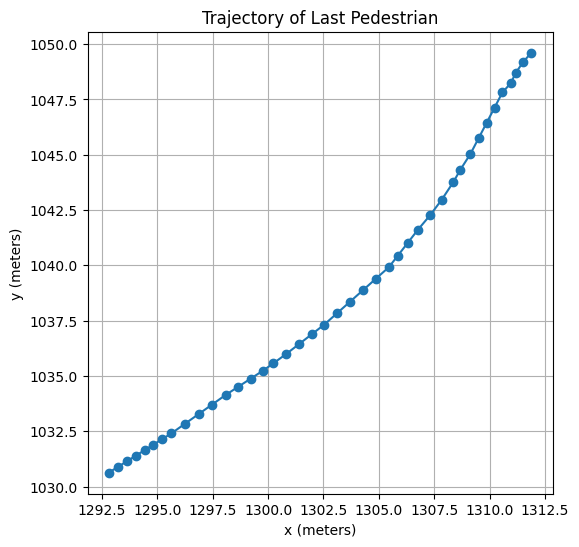

In [9]:
trajectory = np.array(trajectory)

plt.figure(figsize=(6, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o')
plt.title('Trajectory of Last Pedestrian')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.grid(True)
plt.axis('equal')
plt.show()


In [10]:
full_path = os.path.join(dataroot, "pedestrian_dataset.json")
with open(full_path, "r") as f:
    data = json.load(f)
for traj in data[:5]:
    print("agent_id:", traj["agent_id"])
    print(np.array(traj["trajectory"]))
    print()

random.shuffle(data)

n = len(data)
train_split = int(0.7 * n)
val_split = int(0.85 * n)

train_data = data[:train_split]
val_data = data[train_split:val_split]
test_data = data[val_split:]

for name, subset in zip(["train", "val", "test"], [train_data, val_data, test_data]):
    out_path = os.path.join(dataroot, f"{name}.json")
    with open(out_path, "w") as f:
        json.dump(subset, f, indent=2)
    print(f"{name}.json: {len(subset)} trajectories saved.")


agent_id: 0e79e7bed1d543c9a00acfbf90ff60b3
[[ 407.576 1163.308]
 [ 407.573 1163.324]
 [ 407.57  1163.34 ]
 [ 407.569 1163.357]
 [ 407.557 1163.232]
 [ 407.559 1163.175]
 [ 407.581 1163.163]
 [ 407.602 1163.151]
 [ 407.602 1163.151]
 [ 407.602 1163.151]
 [ 407.602 1163.151]
 [ 407.602 1163.151]
 [ 407.602 1163.151]
 [ 407.607 1163.152]
 [ 407.612 1163.153]
 [ 407.617 1163.155]
 [ 407.622 1163.156]
 [ 407.622 1163.156]
 [ 407.622 1163.156]
 [ 407.622 1163.156]
 [ 407.622 1163.156]
 [ 407.622 1163.156]]

agent_id: ebcd168fd25247f68482853796c9327f
[[ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.208 1784.92 ]
 [ 711.166 1784.932]
 [ 711.124 1784.942]
 [ 711.082 1784.95 ]
 [ 711.074 1784.917]
 [ 711.066 1784.884]
 [ 711.058 1784.851]]

agent_id: 68a40df2846e4298af0417ea12721b5c
[[ 619.03  1648.941]
 [ 618.43  1649.273]
 [ 617

A* ALGORITHM IMPLEMENTATION

Start: (730, 5296)
Finish (16479, 11538)


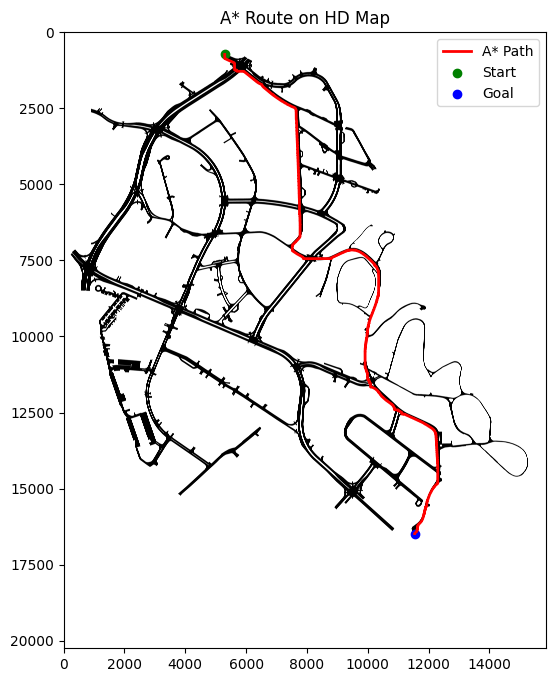

In [11]:
dataroot = r"C:\nuscenes_project\dataset"  
map_filename = "53992ee3023e5494b90c316c183be829.png"  
map_path = os.path.join(dataroot, "maps", map_filename)
map_img = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)


if map_img is None:
    raise ValueError(f"Image has not been loaded {map_path}")

#Binarization
_, occ_grid = cv2.threshold(map_img, 250, 1, cv2.THRESH_BINARY_INV)  # 0 - go, 1 - unable to go

#A* algorithm
def astar(grid, start, goal):
    rows, cols = grid.shape
    open_set = []
    heappush(open_set, (0 + np.linalg.norm(np.array(start) - goal), 0, start))
    came_from = {}
    cost_so_far = {start: 0}

    while open_set:
        _, cost, current = heappop(open_set)
        if current == goal:
            break
        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor] == 0:
                    new_cost = cost + 1
                    if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                        cost_so_far[neighbor] = new_cost
                        priority = new_cost + np.linalg.norm(np.array(neighbor) - goal)
                        heappush(open_set, (priority, new_cost, neighbor))
                        came_from[neighbor] = current
    path = []
    node = goal
    while node != start:
        path.append(node)
        node = came_from.get(node)
        if node is None:
            return []  #path has nt been found
    path.append(start)
    path.reverse()
    return path

#Start and finish
free_cells = np.argwhere(occ_grid == 0)
if len(free_cells) < 2:
    raise ValueError("Not enough free points on the map!")

start = tuple(free_cells[0])
goal = tuple(free_cells[-1])

print("Start:", start)
print("Finish", goal)

#A* 
path = astar(occ_grid, start, goal)
if not path:
    raise ValueError("Path is not found")


plt.figure(figsize=(8, 8))
plt.imshow(occ_grid, cmap='gray')

path_x, path_y = zip(*path)

plt.plot(path_y, path_x, 'r-', linewidth=2, label='A* Path')
plt.scatter([start[1]], [start[0]], c='green', label='Start')
plt.scatter([goal[1]], [goal[0]], c='blue', label='Goal')
plt.legend()
plt.title("A* Route on HD Map")
plt.show()


In [12]:
#print("Путь к карте:", map_path)
#print("Существует ли файл?", os.path.exists(map_path))


In [13]:
step = 500
short_path = path[::step]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(occ_grid, cmap='gray')
ax.set_title("Agent Movement Along A* Route")
ax.axis("off")
ax.invert_yaxis()

short_y, short_x = zip(*short_path)
ax.plot(short_x, short_y, 'r-', linewidth=2, label='A* Path')
ax.scatter([start[1]], [start[0]], c='green', s=50, label='Start')
ax.scatter([goal[1]], [goal[0]], c='blue', s=50, label='Goal')
agent_dot, = ax.plot([], [], 'go', markersize=8, label='Agent')
ax.legend()

#animation
def init():
    agent_dot.set_data([], [])
    return agent_dot,

def animate(i):
    agent_dot.set_data(short_path[i][1], short_path[i][0])
    return agent_dot,

anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(short_path), interval=80, blit=True
)

#save gif
anim.save("agent_movement.gif", writer='pillow', fps=10)
print(" Animation saved as agent_movement.gif")
plt.close()

 Animation saved as agent_movement.gif


In [14]:
print(f"Path length: {len(path)}")

Path length: 25524


In [15]:
#for p in path:
#    if p[0] >= occ_grid.shape[0] or p[1] >= occ_grid.shape[1]:
#        print("Выход за границы:", p)

In [16]:
#Scenes for uniting
scenes = [
    "bookstore/video0",
    "coupa/video0",
    "deathCircle/video0",
    "gates/video0",
    "hyang/video0"
]

#directory where annotations.txt file is
base_dir = r"C:\Users\kotie\OneDrive\Рабочий стол\annotations"
output_dir = "sdd_data"
os.makedirs(output_dir, exist_ok=True)
all_trajectories = []

for scene in scenes:
    anno_path = os.path.join(base_dir, scene, "annotations.txt")
    if not os.path.exists(anno_path):
        print(f"Skipped: file has not been found — {anno_path}")
        continue
    data = []
    with open(anno_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 9:
                frame = int(parts[0])
                obj_id = int(parts[1])
                x = float(parts[2])
                y = float(parts[3])
                obj_class = parts[9].strip('"').lower()
                if obj_class == "pedestrian":
                    data.append((frame, obj_id, x, y))
    #pandas DataFrame
    df = pd.DataFrame(data, columns=['frame', 'id', 'x', 'y'])

    #Group by agents 
    for agent_id, group in df.groupby('id'):
        group = group.sort_values(by='frame')
        coords = group[['x', 'y']].values
        if len(coords) >= 20:
    #check if agent is moving 
            if np.allclose(coords, coords[0], atol=1e-2):
                continue  #skip if agent is not moving 

            all_trajectories.append({
                "agent_id": int(agent_id),
                "trajectory": coords.tolist(),
                "origin": coords[0].tolist()  #saving start point
            })
print(f"Collected {len(all_trajectories)} valid trajectories from {len(scenes)} scenes")

#shuffling and dividing into train / val / test
random.seed(42)
random.shuffle(all_trajectories)
n = len(all_trajectories)
splits = {
    "train": all_trajectories[:int(0.7 * n)],
    "val": all_trajectories[int(0.7 * n):int(0.85 * n)],
    "test": all_trajectories[int(0.85 * n):]
}

#saving
for name, subset in splits.items():
    with open(os.path.join(output_dir, f"{name}.json"), "w") as f:
        json.dump(subset, f, indent=2)
    print(f"Saved {name}.json: {len(subset)} trajectories")


Collected 3548 valid trajectories from 5 scenes
Saved train.json: 2483 trajectories
Saved val.json: 532 trajectories
Saved test.json: 533 trajectories


In [17]:
#pedestrian_dataset.json loading
with open(os.path.join(dataroot, "pedestrian_dataset.json")) as f:
    all_traj = json.load(f)

#choosing one of pedestrians
first = all_traj[0]
first_id = first['agent_id']
coords = first['trajectory']

#turnung into DataFrame
agent_traj = pd.DataFrame(coords, columns=['x', 'y'])
agent_traj['frame'] = range(len(agent_traj))  


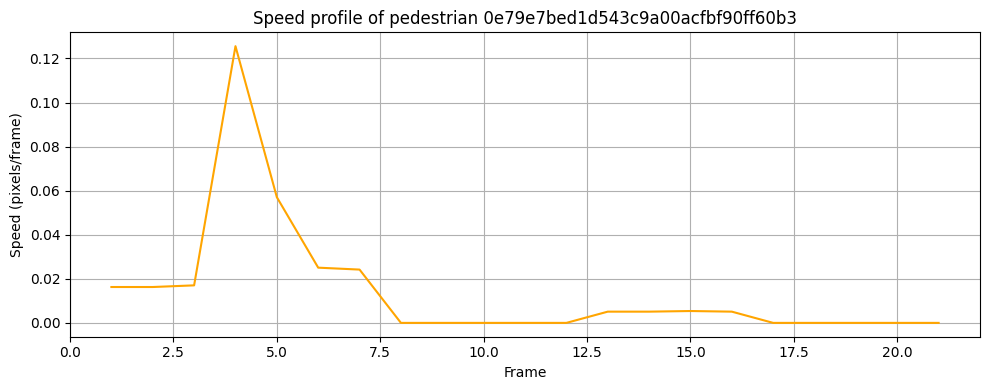

In [18]:
# differences
agent_traj['dx'] = agent_traj['x'].diff()
agent_traj['dy'] = agent_traj['y'].diff()
agent_traj['dt'] = agent_traj['frame'].diff()

#0 and - time intervals deleting
agent_traj = agent_traj[agent_traj['dt'] > 0]

#Speed = distance/time 
agent_traj['speed'] = np.sqrt(agent_traj['dx']**2 + agent_traj['dy']**2) / agent_traj['dt']


plt.figure(figsize=(10, 4))
plt.plot(agent_traj['frame'], agent_traj['speed'], color='orange')
plt.xlabel("Frame")
plt.ylabel("Speed (pixels/frame)")
plt.title(f"Speed profile of pedestrian {first_id}")
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
class UnifiedTrajectoryDataset(Dataset):
    def __init__(self, path, obs_len=8, pred_len=12, source='sdd', add_noise=False):
        with open(path, 'r') as f:
            self.trajectories = json.load(f)

        self.obs_len = obs_len
        self.pred_len = pred_len
        self.source = source
        self.add_noise = add_noise
        self.pixel_to_meter = 0.05 if self.source == 'sdd' else 1.0

        if self.source == 'sdd':
            self.grouped_data = self._group_sdd_by_scene()
        else:
            self.grouped_data = self._single_agent_format()

    def _group_sdd_by_scene(self):
        scene_dict = {}

        for traj_entry in self.trajectories:
            scene_id = traj_entry.get('scene_id', 'default')
            traj = np.array(traj_entry['trajectory']) * self.pixel_to_meter
            if len(traj) < self.obs_len + self.pred_len:
                continue

            for i in range(len(traj) - self.obs_len - self.pred_len + 1):
                window = traj[i:i + self.obs_len + self.pred_len]
                key = f"{scene_id}_{i}"
                if key not in scene_dict:
                    scene_dict[key] = []
                scene_dict[key].append(window)

        #filtration by number of agents in frame - min 2
        filtered = {k: v for k, v in scene_dict.items() if len(v) >= 2}
        return list(filtered.values())

    def _single_agent_format(self):
        data = []
        for traj_entry in self.trajectories:
            traj = np.array(traj_entry['trajectory']) * self.pixel_to_meter
            if len(traj) >= self.obs_len + self.pred_len:
                for i in range(len(traj) - self.obs_len - self.pred_len + 1):
                    window = traj[i:i + self.obs_len + self.pred_len]
                    data.append([window])
        return data

    def __len__(self):
        return len(self.grouped_data)

    def __getitem__(self, idx):
        agents = self.grouped_data[idx]
        obs_list, pred_list, origin_list, scale_list = [], [], [], []
    
        for traj in agents:
            origin = traj[0].copy()
            scale = np.linalg.norm(traj[-1] - traj[0]) + 1e-6
            if scale < 0.5:
                continue
            normed = (traj - origin) / scale
            if self.add_noise:
                normed += np.random.normal(0, 0.05, normed.shape)
            obs = normed[:self.obs_len]
            pred = normed[self.obs_len:]
            obs_list.append(torch.tensor(obs, dtype=torch.float32))
            pred_list.append(torch.tensor(pred, dtype=torch.float32))
            origin_list.append(torch.tensor(origin, dtype=torch.float32))
            scale_list.append(torch.tensor(scale, dtype=torch.float32))
    
        if len(obs_list) == 0:
            return self.__getitem__((idx + 1) % len(self))
    
        return (
            torch.stack(obs_list),
            torch.stack(pred_list),
            torch.stack(origin_list),
            torch.stack(scale_list)
        )



In [20]:
def hybrid_collate(batch):
    obs_list, target_list, origin_list, scale_list = [], [], [], []

    for obs, target, origin, scale in batch:
        obs_list.append(obs)
        target_list.append(target)
        origin_list.append(origin)
        scale_list.append(scale)

    neighbors_list = [None] * len(batch)  

    return obs_list, target_list, neighbors_list, origin_list, scale_list


SOCIAL-LSTM IMPLEMENTATION

In [21]:
class SocialLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, num_layers=1, neighborhood_size=4.0, grid_size=8):
        super(SocialLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.grid_size = grid_size
        self.neighborhood_size = neighborhood_size

        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.hidden2pos = nn.Linear(hidden_dim, output_dim)

    def get_social_tensor(self, hidden_states, positions):
        """
        hidden_states: (N, hidden_dim)
        positions: (N, 2) – absolute positions
        returns: (N, hidden_dim) – social tensor
        """
        N = hidden_states.size(0)
        device = hidden_states.device
        social_tensor = torch.zeros(N, self.hidden_dim, device=device)

        for i in range(N):
            rel_pos = positions - positions[i]  # (N, 2)
            within_range = (rel_pos.norm(dim=1) < self.neighborhood_size)
            neighbors = hidden_states[within_range]
            if len(neighbors) > 1:
                pooled = neighbors.mean(dim=0)
            else:
                pooled = torch.zeros_like(hidden_states[i])
            social_tensor[i] = pooled
        return social_tensor

    def forward(self, obs):
        """
        obs: Tensor of shape (N, T, 2), where N — number of agents in scene.
        """
        N, T, D = obs.shape
        _, (h_n, c_n) = self.encoder(obs)  # h_n: (1, N, hidden)
    
        #Social pooling
        h = h_n[0]  # (N, hidden)
        last_pos = obs[:, -1]  # (N, 2)
        social = self.get_social_tensor(h, last_pos)  #(N, hidden)
    
        #Decoder input: [N, 12, D + hidden]
        dec_input = torch.zeros((N, 12, D), device=obs.device)
        social_repeated = social.unsqueeze(1).expand(-1, 12, -1)
        dec_input_cat = torch.cat([dec_input, social_repeated], dim=-1)
    
        #decoder
        h = h.unsqueeze(0)  #(1, N, hidden)
        c = c_n[0].unsqueeze(0)  #(1, N, hidden)
        dec_out, _ = self.decoder(dec_input_cat, (h, c))
    
        pred = self.hidden2pos(dec_out)  #(N, 12, 2)
        return pred



In [22]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            obs_batch, target_batch, _, origin_batch, scale_batch = batch  # игнорируем neighbors_list
            for obs, target, origin, scale in zip(obs_batch, target_batch, origin_batch, scale_batch):
                obs = obs.to(device)
                target = target.to(device)
                scale = scale.to(device).unsqueeze(-1).unsqueeze(-1)

                pred = model(obs)  # [N_agents, pred_len, 2]
                pred = pred * scale
                target = target * scale

                loss = torch.mean(torch.norm(pred - target, dim=2))  # ADE

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_train = total_loss / len(train_loader)

        #validation
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                obs_batch, target_batch, _, origin_batch, scale_batch = batch
                for obs, target, origin, scale in zip(obs_batch, target_batch, origin_batch, scale_batch):
                    obs = obs.to(device)
                    target = target.to(device)
                    scale = scale.to(device).unsqueeze(-1).unsqueeze(-1)

                    pred = model(obs)
                    pred = pred * scale
                    target = target * scale

                    val_loss += torch.mean(torch.norm(pred - target, dim=2)).item()

        avg_val = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/4")

        if patience_counter >= 4:
            print("Early stopping triggered.")
            break


In [23]:
val_dataset = UnifiedTrajectoryDataset("C:/nuscenes_project/dataset/pedestrian_dataset.json", source='nuscenes')
train_dataset = UnifiedTrajectoryDataset("sdd_data/train.json", source='sdd')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=hybrid_collate)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=hybrid_collate)

model = SocialLSTM()
print("Number of scenes in training set:", len(train_dataset))
train_model(model, train_loader, val_loader)


Number of scenes in training set: 7220
Epoch 1, Train Loss: 331.8117, Val Loss: 344.2627
Best model saved
Epoch 2, Train Loss: 313.5192, Val Loss: 345.1356
No improvement. Patience: 1/4
Epoch 3, Train Loss: 307.2732, Val Loss: 276.6101
Best model saved
Epoch 4, Train Loss: 303.2607, Val Loss: 226.6372
Best model saved
Epoch 5, Train Loss: 300.4060, Val Loss: 201.2947
Best model saved
Epoch 6, Train Loss: 298.4602, Val Loss: 186.9217
Best model saved
Epoch 7, Train Loss: 296.0705, Val Loss: 215.3657
No improvement. Patience: 1/4
Epoch 8, Train Loss: 295.5658, Val Loss: 206.2913
No improvement. Patience: 2/4
Epoch 9, Train Loss: 299.5823, Val Loss: 177.0590
Best model saved
Epoch 10, Train Loss: 293.0544, Val Loss: 189.8100
No improvement. Patience: 1/4
Epoch 11, Train Loss: 291.2933, Val Loss: 183.9078
No improvement. Patience: 2/4
Epoch 12, Train Loss: 289.3954, Val Loss: 162.8227
Best model saved
Epoch 13, Train Loss: 288.3469, Val Loss: 181.3336
No improvement. Patience: 1/4
Epoch 14

In [24]:
def evaluate_model(model, data_loader):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    ade_total, fde_total, rmse_total = 0, 0, 0
    n = 0

    with torch.no_grad():
        for batch in data_loader:
            if len(batch) == 5:
                obs_batch, target_batch, _, origin_batch, scale_batch = batch
                neighbors_list = None
            else:
                obs_batch, target_batch, neighbors_list, origin_batch, scale_batch = batch

            for obs, target, origin, scale in zip(obs_batch, target_batch, origin_batch, scale_batch):
                obs = obs.to(device)
                target = target.to(device)
                
                scale = scale.to(device).view(-1, 1, 1)
                origin = origin.to(device).view(-1, 1, 2)
                
                if neighbors_list is None:
                    neighbors_list = [torch.zeros((0, obs.shape[1], 2), device=device) for _ in range(obs.size(0))]
                
                pred_normed = model(obs)

                
                pred_world = pred_normed * scale + origin
                target_world = target * scale + origin

                #evaluation  metrics
                #ADE
                ade = torch.norm(pred_world - target_world, dim=2).mean(dim=1)
                ade_total += ade.sum().item()
                # FDE
                fde = torch.norm(pred_world[:, -1, :] - target_world[:, -1, :], dim=1)
                fde_total += fde.sum().item()
                # RMSE
                mse = ((pred_world - target_world) ** 2).mean()
                rmse = torch.sqrt(mse)
                rmse_total += rmse.item() * obs.size(0)

                n += obs.size(0)

    ade = ade_total / n
    fde = fde_total / n
    rmse = rmse_total / n

    print("Evaluation Results:")
    print(f" ADE  : \033[92m{ade:.4f}\033[0m pixels")
    print(f" FDE  : \033[91m{fde:.4f}\033[0m pixels")
    print(f" RMSE : \033[94m{rmse:.4f}\033[0m pixels")

    return ade, fde, rmse


In [25]:
def visualize_prediction(model, dataset, index=0):
    model.eval()
    model = model.to("cpu")

    item = dataset[index]

    if len(item) == 5:
        obs, target, origin, astar, scale = item
        astar_np = astar.cpu().numpy() * scale.item() + origin.cpu().numpy()
    else:
        obs, target, origin, scale = item
        astar_np = None

    #[N, T, 2]
    obs = obs.cpu()
    target = target.cpu()
    origin = origin.cpu()
    scale = scale.cpu().unsqueeze(-1)  #[N, 1]

    with torch.no_grad():
        pred = model(obs).cpu()  #[N, 12, 2]

    #dеnormalisation
    obs_np = obs.numpy() * scale.numpy() + origin.numpy()  #[N, 8, 2]
    tgt_np = target.numpy() * scale.numpy() + origin.numpy()
    pred_np = pred.numpy() * scale.numpy() + origin.numpy()

    plt.figure(figsize=(6, 6))
    for i in range(obs_np.shape[0]):
        plt.plot(obs_np[i, :, 0], obs_np[i, :, 1], 'bo-', label="Observed" if i == 0 else "")
        plt.plot(tgt_np[i, :, 0], tgt_np[i, :, 1], 'g^-', label="Ground Truth" if i == 0 else "")
        plt.plot(pred_np[i, :, 0], pred_np[i, :, 1], 'ro--', label="Predicted" if i == 0 else "")

    if astar_np is not None:
        plt.plot(astar_np[:, 0], astar_np[:, 1], 'k:', label="A*")

    plt.legend()
    plt.title(f"Trajectory comparison (index={index})")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


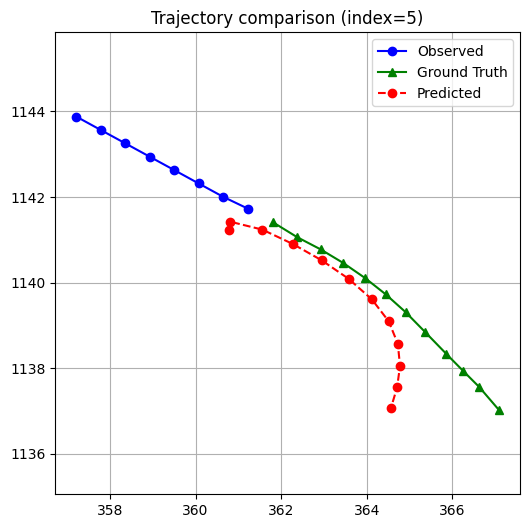

In [26]:
visualize_prediction(model, val_dataset, index=5)

In [27]:
def visualize_worst_case(model, dataset, N=5):
    model.eval()
    model = model.to("cpu")
    worst_errors = []

    for i in range(len(dataset)):
        obs, target, origin = dataset[i]
        pred = model(obs.unsqueeze(0)).squeeze(0).detach()
        error = torch.norm(pred - target).item()
        worst_errors.append((error, i))

    worst_errors.sort(reverse=True)
    print(f"worst predicted indexes: {[i for _, i in worst_errors[:N]]}")

    for _, idx in worst_errors[:N]:
        visualize_prediction(model, dataset, index=idx)


In [28]:
torch.save(model.state_dict(), "social_lstm_sdd.pth")
print("Model saved to social_lstm_sdd.pth")
#visualize_worst_case(model, val_dataset, N=3)

Model saved to social_lstm_sdd.pth


In [29]:
#test dataset
test_dataset = UnifiedTrajectoryDataset("sdd_data/test.json", source="sdd")
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=hybrid_collate)




evaluate_model(model, test_loader)


Evaluation Results:
 ADE  : 8.5698 pixels
 FDE  : 7.1474 pixels
 RMSE : 10.8277 pixels


(8.569809726901182, 7.147360274831465, 10.827707178998374)

In [30]:
nusc_dataset_path = "C:/nuscenes_project/dataset/pedestrian_dataset.json" 

nusc_dataset = UnifiedTrajectoryDataset(nusc_dataset_path, source="nuscenes")
nusc_loader = DataLoader(nusc_dataset, batch_size=64, collate_fn=hybrid_collate)


In [31]:
model.load_state_dict(torch.load("social_lstm_sdd.pth", map_location=torch.device('cpu')))
model.eval()

SocialLSTM(
  (encoder): LSTM(2, 64, batch_first=True)
  (decoder): LSTM(66, 64, batch_first=True)
  (hidden2pos): Linear(in_features=64, out_features=2, bias=True)
)

In [32]:
evaluate_model(model, nusc_loader)


Evaluation Results:
 ADE  : 2.6186 pixels
 FDE  : 4.1228 pixels
 RMSE : 2.0379 pixels


(2.618595338498478, 4.122778466376389, 2.03792932024159)

In [42]:
import os, heapq
import cv2, torch
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

def run_path_prediction_from_png(
    map_path, free_cells, model, save_img_path='ml_route.png', downsample_factor=10
):
    # map loading 
    if isinstance(map_path, (str, bytes, os.PathLike)):
        img = cv2.imread(str(map_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"was not possible to open an image  {map_path}")
    elif isinstance(map_path, np.ndarray):
        img = map_path
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        raise TypeError("map_path should be a path to the file or numpy array")

    #downsampling -- i had a ram error
    h, w = img.shape[:2]
    ds = max(1, int(downsample_factor))
    occ_grid = cv2.resize(
        img,
        (max(1, w // ds), max(1, h // ds)),
        interpolation=cv2.INTER_NEAREST
    )

    start_raw_full, goal_raw_full = tuple(free_cells[0]), tuple(free_cells[-1])
    start_raw = (np.array(start_raw_full) / ds).astype(int)
    goal_raw  = (np.array(goal_raw_full)  / ds).astype(int)

    free_mask = (occ_grid < 10)
    ys, xs = np.where(free_mask)
    free_coords = np.stack([ys, xs], axis=1)
    if free_coords.size == 0:
        raise ValueError("No free cells (free_coords is empty)")
    tree = cKDTree(free_coords)

    _, start_idx = tree.query(tuple(start_raw))
    _, goal_idx  = tree.query(tuple(goal_raw))
    start = tuple(free_coords[start_idx])
    goal  = tuple(free_coords[goal_idx])

    if len(free_coords) > 10000:
        idx = np.random.choice(len(free_coords) - 1, size=10000, replace=False)
        sampled = free_coords[idx]
        diffs = np.diff(sampled, axis=0)
        norms = np.linalg.norm(diffs, axis=1)
        scale = float(np.mean(norms) * 5)
    else:
        scale = 10.0

    def normalize_traj(traj):   return (np.array(traj) - traj[0]) / scale
    def denormalize_traj(n, o): return n * scale + o

    traj = np.array([start + np.array([i * 0.5, 0]) for i in range(8)], dtype=np.float32)
    generated = [start]
    visited = {tuple(start)}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()
    print(f"[INFO] Start {start} (full {start_raw_full}) -> Goal {goal} (full {goal_raw_full})")

    def find_fallback_unvisited_chunked(free_coords, goal, visited, k=200, chunk_size=100_000):
        n = free_coords.shape[0]
        min_heap = []
        for i in range(0, n, chunk_size):
            chunk = free_coords[i:i+chunk_size]
            dists = np.linalg.norm(chunk - goal, axis=1)
            idx_sorted = np.argsort(dists)
            for j in idx_sorted[:min(k, len(idx_sorted))]:
                cand = tuple(chunk[j])
                if cand not in visited:
                    heapq.heappush(min_heap, (dists[j], cand))
        result, seen = [], set()
        while min_heap and len(result) < k:
            _, cand = heapq.heappop(min_heap)
            if cand not in seen:
                result.append(cand); seen.add(cand)
        return result

    with torch.no_grad():
        for step in range(300):
            input_seq = torch.tensor(
                normalize_traj(traj[-8:]), dtype=torch.float32
            ).unsqueeze(0).to(device)

            output_seq = model(input_seq)[0].cpu().numpy()
            next_step  = denormalize_traj(output_seq[-1], traj[0])

            direction = next_step - traj[-1]
            norm = np.linalg.norm(direction)
            if norm > 15:
                next_step = traj[-1] + direction / norm

            _, idxs = tree.query(next_step, k=20)
            added = False
            for idx in np.atleast_1d(idxs):
                cand = tuple(free_coords[idx])
                if cand not in visited:
                    traj = np.vstack([traj, cand])
                    generated.append(cand)
                    visited.add(cand)
                    print(f"[{step}] step {cand}")
                    added = True
                    break

            if not added:
                print(f"[{step}] fallback…")
                for fb in find_fallback_unvisited_chunked(free_coords, goal, visited):
                    traj = np.vstack([traj, fb])
                    generated.append(fb)
                    visited.add(fb)
                    print(f"[{step}] fallback {fb}")
                    added = True
                    break
                if not added:
                    print(f"[{step}] stuck"); break

            if np.linalg.norm(np.array(generated[-1]) - np.array(goal)) < 15:
                print(f"[{step}] goal reached"); break


    vis = np.array([[p[1], p[0]] for p in generated])
    start_disp = np.array(start)[[1, 0]]
    goal_disp  = np.array(goal)[[1, 0]]

    plt.figure(figsize=(10, 10))
    plt.imshow(occ_grid, cmap='gray')      
    if vis.shape[0] > 1:
        plt.plot(vis[:, 0], vis[:, 1], linewidth=2, color='orange', label='Trajectory')
    plt.scatter([start_disp[0]], [start_disp[1]], c='blue', s=50, label='Start')
    plt.scatter([goal_disp[0]],  [goal_disp[1]],  c='red',  s=50, label='Goal')
    plt.title("ML route (downsampled map)")
    plt.legend(); plt.axis('off'); plt.gca().invert_yaxis()
    plt.savefig(save_img_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.close()
    print(f"[INFO] Saved to {save_img_path}")


In [43]:
run_path_prediction_from_png(occ_grid, free_cells, model, "ml_route.png", 10)


[INFO] Start (73, 529) (full (730, 5296)) -> Goal (1647, 1153) (full (16479, 11538))
[0] step (77, 530)
[1] step (86, 541)
[2] step (86, 542)
[3] step (87, 542)
[4] step (86, 543)
[5] step (87, 543)
[6] step (85, 542)
[7] step (87, 541)
[8] step (85, 541)
[9] step (86, 540)
[10] step (87, 540)
[11] step (85, 540)
[12] step (86, 539)
[13] step (85, 539)
[14] step (87, 539)
[15] step (84, 540)
[16] step (88, 540)
[17] step (88, 541)
[18] step (84, 541)
[19] step (88, 542)
[20] step (85, 543)
[21] step (84, 542)
[22] fallback…
[22] fallback (1647, 1153)
[22] goal reached
[INFO] Saved to ml_route.png


In [44]:
dataroot = r"C:\nuscenes_project\dataset"
version = "v1.0-mini"

nusc = NuScenes(version=version, dataroot=dataroot, verbose=False)

#get all the pedestrians' annotations
pedestrian_annos = [
    ann for ann in nusc.sample_annotation if ann['category_name'].startswith('human.pedestrian')
]

#grouping annotations by pedestrian
pedestrian_by_token = defaultdict(list)
for ann in pedestrian_annos:
    pedestrian_by_token[ann['instance_token']].append(ann)

#grouping by scene 
scenes = defaultdict(list)

for token, annos in pedestrian_by_token.items():
    sorted_annos = sorted(annos, key=lambda a: nusc.get('sample', a['sample_token'])['timestamp'])

    trajectory = []
    for ann in sorted_annos:
        x, y = ann['translation'][:2]
        trajectory.append([x, y])
    
    if len(trajectory) >= 20:
        traj_arr = np.array(trajectory)

        scene_token = nusc.get('sample', sorted_annos[0]['sample_token'])['scene_token']
        scenes[scene_token].append({
            "agent_id": token,
            "trajectory": traj_arr.tolist()
        })

output = []
for i, (scene_token, agents) in enumerate(scenes.items()):
    output.append({
        "scene_id": i,
        "agents": agents
    })

output_path = os.path.join(dataroot, "social_lstm_scenes.json")
with open(output_path, "w") as f:
    json.dump(output, f, indent=2)

print(f"Scenes saved: {len(output)}")
print(f"To file: {output_path}")


Scenes saved: 9
To file: C:\nuscenes_project\dataset\social_lstm_scenes.json


In [45]:
dataroot = r"C:\nuscenes_project\dataset"
input_path = os.path.join(dataroot, "social_lstm_scenes.json")
output_path = os.path.join(dataroot, "social_lstm_windows.json")

obs_len = 8
pred_len = 12
min_len = obs_len + pred_len

with open(input_path, "r") as f:
    scenes = json.load(f)

windows = []

for scene in tqdm(scenes):
    agents = scene["agents"]
    for agent in agents:
        traj = np.array(agent["trajectory"])  # shape: (T, 2)
        if traj.shape[0] < min_len:
            continue
        for i in range(traj.shape[0] - min_len + 1):
            segment = traj[i:i+min_len]
            windows.append({
                "scene_id": scene["scene_id"],
                "agent_id": agent["agent_id"],
                "trajectory": segment.tolist()
            })

with open(output_path, "w") as f:
    json.dump(windows, f, indent=2)

print(f"Total windows: {len(windows)} saved to {output_path}")


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1497.55it/s]

Total windows: 1398 saved to C:\nuscenes_project\dataset\social_lstm_windows.json


In [46]:
class SocialLSTMFullDataset(Dataset):
    def __init__(self, json_path, obs_len=8, pred_len=12):
        with open(json_path, 'r') as f:
            self.data = json.load(f)

        self.obs_len = obs_len
        self.pred_len = pred_len
        self.windows = []
        for scene in self.data:
            agents = scene["agents"]
            for agent in agents:
                traj = np.array(agent["trajectory"])
                if traj.shape[0] < obs_len + pred_len:
                    continue
                for i in range(traj.shape[0] - (obs_len + pred_len) + 1):
                    segment = traj[i:i + obs_len + pred_len]
                    self.windows.append({
                        "scene_id": scene["scene_id"],
                        "agent_id": agent["agent_id"],
                        "trajectory": segment.tolist(),
                        "agents": [
                            a for a in agents if a["agent_id"] != agent["agent_id"]
                        ]
                    })

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        entry = self.windows[idx]
        traj = torch.tensor(entry["trajectory"], dtype=torch.float32)
        origin = traj[0].clone()
        scale = torch.norm(traj[-1] - traj[0]) + 1e-6
        normed = (traj - origin) / scale
    
        obs = normed[:self.obs_len]
        pred = normed[self.obs_len:]
    
        max_neighbors = 10  
        neighbors_tensor = torch.zeros((max_neighbors, self.obs_len, 2), dtype=torch.float32)
    
        count = 0
        for other in entry["agents"]:
            if count >= max_neighbors:
                break
            other_traj = np.array(other["trajectory"])
            if len(other_traj) < self.obs_len:
                continue
            normed_other = (other_traj[:self.obs_len] - origin.numpy()) / scale
            neighbors_tensor[count, :self.obs_len] = torch.tensor(normed_other, dtype=torch.float32)
            count += 1
    
        return obs, pred, neighbors_tensor, origin, scale


HYBRID ARCHITECTURE IMPLEMENTATION

In [47]:
class SocialPooling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SocialPooling, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, self_traj, neighbors):
        B, T, _ = self_traj.shape
        pooled_neighbors_list = []

        for i in range(B):
            if neighbors[i].sum() == 0:
                pooled = torch.zeros((T, self.rnn.hidden_size), device=self_traj.device)
            else:
                out, _ = self.rnn(neighbors[i])  # [N, T, H]
                pooled, _ = torch.max(out, dim=0)  # [T, H]
            pooled_neighbors_list.append(pooled)

        pooled_neighbors = torch.stack(pooled_neighbors_list, dim=0)  # [B, T, H]
        return pooled_neighbors

class SocialLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_len=12):
        super(SocialLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_len = output_len

        self.self_encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.pooling = SocialPooling(input_dim, hidden_dim)

        self.combined = nn.Linear(2 * hidden_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, self_traj, neighbors_list):
        self_out, (h_self, _) = self.self_encoder(self_traj)
        last_hidden = self_out[:, -1, :]  # [B, H]

        pooled = self.pooling(self_traj, neighbors_list)
        pooled_last = pooled[:, -1, :]  # [B, H]

        combined = torch.cat([last_hidden, pooled_last], dim=1)
        fused = F.relu(self.combined(combined))  # [B, H]

        decoder_input = fused.unsqueeze(1).repeat(1, self.output_len, 1)  # [B, 12, H]
        dec_out, _ = self.decoder(decoder_input)
        pred = self.output(dec_out)  # [B, 12, 2]

        return pred


In [48]:
def social_collate_fn(batch):
    obs, pred, neighbors, origin, scale = zip(*batch)
    
    obs = torch.stack(obs)
    pred = torch.stack(pred)
    origin = torch.stack(origin)
    scale = torch.stack(scale)
    return obs, pred, neighbors, origin, scale #neighbors — list of tensors in different [B_i, T, 2]


In [49]:
dataroot = r"C:\nuscenes_project\dataset"
json_path = os.path.join(dataroot, "social_lstm_scenes.json")

model_path = os.path.join(dataroot, "social_lstm_with_pooling.pth")

obs_len = 8
pred_len = 12
batch_size = 64
epochs = 20
lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [50]:
dataset = SocialLSTMFullDataset(json_path, obs_len=obs_len, pred_len=pred_len)
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=social_collate_fn  
)


model = SocialLSTM(input_dim=2, hidden_dim=64, output_len=12)

In [51]:
def train_social_lstm(model, dataloader, device, epochs=20, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for batch in dataloader:
            obs, pred, neighbors_list, _, _ = batch 

            obs = obs.to(device)
            pred = pred.to(device)

            neighbors_list = [n.to(device) for n in neighbors_list]

            optimizer.zero_grad()
            output = model(obs, neighbors_list)  #list!
            loss = criterion(output, pred)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"[{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


In [52]:
train_social_lstm(model, dataloader, device, epochs=epochs, lr=lr)
torch.save(model.state_dict(), model_path)
print("Model saved", model_path)


C:\Users\kotie\AppData\Local\Temp\ipykernel_9384\1038971583.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbors_tensor[count, :self.obs_len] = torch.tensor(normed_other, dtype=torch.float32)


[1/20] Loss: 0.3566
[2/20] Loss: 0.2603
[3/20] Loss: 0.1541
[4/20] Loss: 0.1261
[5/20] Loss: 0.1201
[6/20] Loss: 0.1110
[7/20] Loss: 0.1041
[8/20] Loss: 0.0987
[9/20] Loss: 0.0934
[10/20] Loss: 0.0892
[11/20] Loss: 0.0853
[12/20] Loss: 0.0818
[13/20] Loss: 0.0791
[14/20] Loss: 0.0731
[15/20] Loss: 0.0682
[16/20] Loss: 0.0694
[17/20] Loss: 0.0686
[18/20] Loss: 0.0716
[19/20] Loss: 0.0602
[20/20] Loss: 0.0534
Model saved C:\nuscenes_project\dataset\social_lstm_with_pooling.pth


In [53]:
def visualize_lstm_prediction_on_map(model, occ_grid, free_cells, start=None, goal=None, max_steps=300):
    """
    route visualizing from start to goal on occ_grid
    """

    #indexation of free cells
    tree = cKDTree(free_cells)

    #closest start and goal
    if start is None:
        start = tuple(free_cells[0])
    if goal is None:
        goal = tuple(free_cells[-1])

    _, start_idx = tree.query(start)
    _, goal_idx = tree.query(goal)

    start = tuple(free_cells[start_idx])
    goal = tuple(free_cells[goal_idx])

    print(f" Start: {start}, Goal: {goal}")

    #scale, normalization
    def normalize(traj, scale): return (traj - traj[0]) / scale
    def denormalize(traj, origin, scale): return traj * scale + origin

    scale = 10.0
    traj = np.array([start + np.array([i * 0.5, 0]) for i in range(8)], dtype=np.float32)  # начальная траектория
    generated = [start]
    visited = set()
    visited.add(start)

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for step in range(max_steps):
        input_seq = normalize(traj[-8:], scale)
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 8, 2]

        with torch.no_grad():
            empty_neighbors = [torch.zeros((0, 8, 2), device=device)]  # пустой список соседей для одного агента
            output = model(input_tensor, empty_neighbors)[0].cpu().numpy()


        next_step = denormalize(output[-1], traj[0], scale)
        direction = next_step - traj[-1]

        if np.linalg.norm(direction) > 15:
            next_step = traj[-1] + direction / np.linalg.norm(direction) * 5

        dists, idxs = tree.query(next_step, k=20)

        added = False
        for idx in idxs:
            candidate = tuple(free_cells[idx])
            if candidate not in visited:
                traj = np.vstack([traj, candidate])
                generated.append(candidate)
                visited.add(candidate)
                added = True
                break

        if not added:
            print(f"[{step}] fallback to the nearest to goal point")
            goal_dists = np.linalg.norm(free_cells - np.array(goal), axis=1)
            fallback = tuple(free_cells[np.argmin(goal_dists)])
            traj = np.vstack([traj, fallback])
            generated.append(fallback)
            break

        if np.linalg.norm(np.array(generated[-1]) - np.array(goal)) < 10:
            print(f"[{step}] goal achieved")
            break

    vis = np.array([[p[1], p[0]] for p in generated])  #(y, x)
    plt.figure(figsize=(10, 10))
    plt.imshow(occ_grid, cmap='gray')
    plt.plot(vis[:, 0], vis[:, 1], 'orange', linewidth=2, label='Social-LSTM')
    plt.scatter([start[1]], [start[0]], c='blue', s=50, label='Start')
    plt.scatter([goal[1]], [goal[0]], c='red', s=50, label='Goal')
    plt.title("Social-LSTM predicted path on nuScenes map")
    plt.legend()
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.show()


 Start: (730, 5297), Goal: (16479, 11538)
[92] fallback to the nearest to goal point


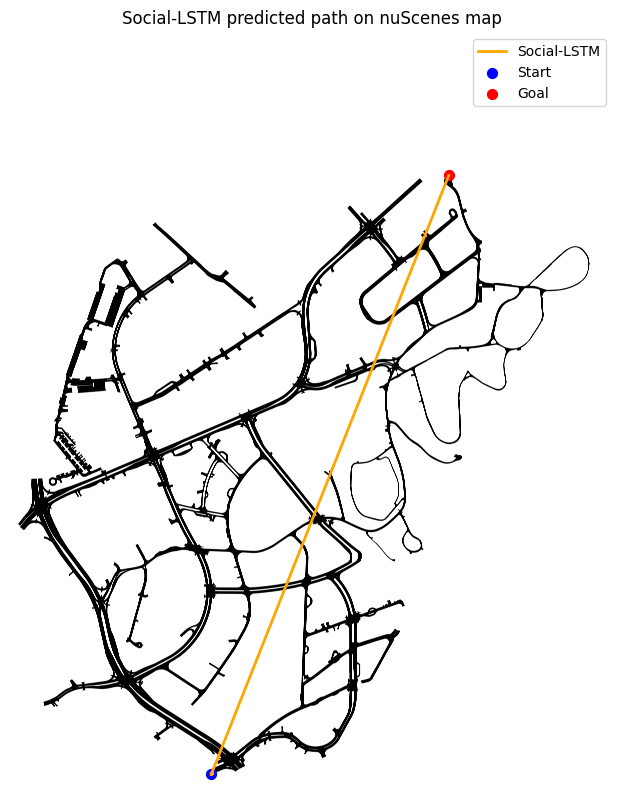

In [54]:
map_path = os.path.join(dataroot, "maps", "53992ee3023e5494b90c316c183be829.png")
map_img = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)
_, occ_grid = cv2.threshold(map_img, 250, 1, cv2.THRESH_BINARY_INV)
free_cells = np.argwhere(occ_grid == 0)

model = SocialLSTM(input_dim=2, hidden_dim=64, output_len=12)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

start = tuple(free_cells[1])
goal = tuple(free_cells[-1])

visualize_lstm_prediction_on_map(model, occ_grid, free_cells, start, goal)


In [55]:
def build_cost_map_from_lstm(model, dataset, occ_grid, free_cells, scale_factor=100.0):
    """
    cost map based on s-lstm predicted ttrajectories
    """
    cost_map = np.zeros_like(occ_grid, dtype=np.float32)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for i in range(len(dataset)):
        obs, _, neighbors, origin, scale = dataset[i]
        obs = obs.to(device).unsqueeze(0)
        neighbors = [n.to(device) for n in [neighbors]]

        with torch.no_grad():
            pred = model(obs, neighbors)[0].cpu().numpy()

        world_coords = (pred * scale.numpy()) + origin.numpy()
        for x, y in world_coords:
            px, py = int(round(y)), int(round(x))  # (y, x)
            if 0 <= px < cost_map.shape[0] and 0 <= py < cost_map.shape[1]:
                cost_map[px, py] += 1.0 


    cost_map = (cost_map / np.max(cost_map + 1e-6)) * scale_factor
    return cost_map


In [56]:
def merge_static_and_dynamic_costs(occ_grid, cost_map, wall_cost=1e6):
    """
    map -> final map for A*
    """
    static_cost = np.where(occ_grid == 1, wall_cost, 1.0)
    return static_cost + cost_map


In [57]:
def astar_with_cost_map(cost_map, start, goal):
    import heapq

    H, W = cost_map.shape
    visited = np.zeros_like(cost_map, dtype=bool)
    came_from = {}

    heap = [(0, start)]
    g_cost = {start: 0}

    def neighbors(p):
        x, y = p
        for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
            nx, ny = x+dx, y+dy
            if 0 <= nx < H and 0 <= ny < W:
                yield (nx, ny)

    while heap:
        f, current = heapq.heappop(heap)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path

        if visited[current]:
            continue
        visited[current] = True

        for neighbor in neighbors(current):
            tentative_g = g_cost[current] + cost_map[neighbor]
            if neighbor not in g_cost or tentative_g < g_cost[neighbor]:
                g_cost[neighbor] = tentative_g
                priority = tentative_g + np.linalg.norm(np.array(goal) - np.array(neighbor))
                heapq.heappush(heap, (priority, neighbor))
                came_from[neighbor] = current

    return None  


In [58]:
def visualize_hybrid_path(occ_grid, hybrid_path, start, goal):
    plt.figure(figsize=(10, 10))
    plt.imshow(occ_grid, cmap='gray')
    path_np = np.array(hybrid_path)
    plt.plot(path_np[:,1], path_np[:,0], 'lime', label='Hybrid A*+LSTM')
    plt.scatter([start[1]], [start[0]], c='blue', s=50, label='Start')
    plt.scatter([goal[1]], [goal[0]], c='red', s=50, label='Goal')
    plt.title(" Hybrid Path (A* + Social-LSTM predictions)")
    plt.legend()
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.show()


C:\Users\kotie\AppData\Local\Temp\ipykernel_9384\1038971583.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbors_tensor[count, :self.obs_len] = torch.tensor(normed_other, dtype=torch.float32)


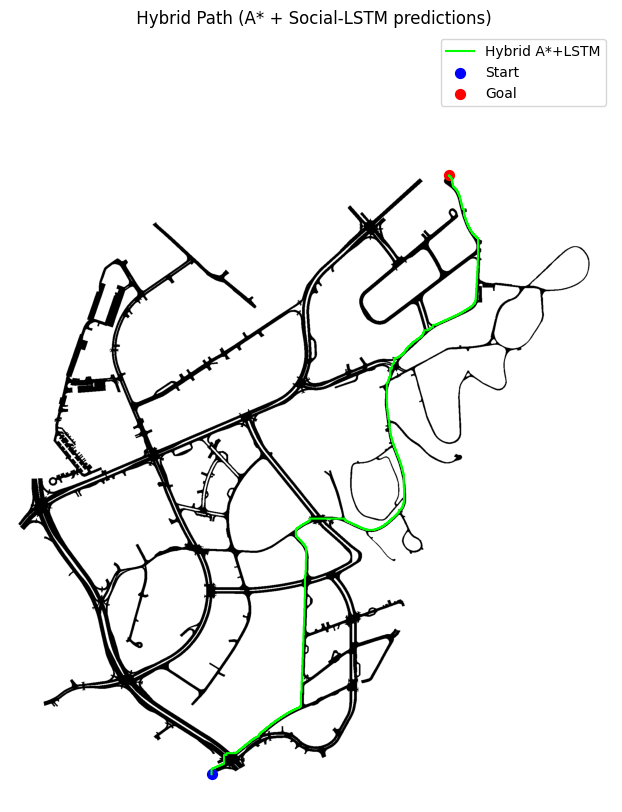

In [59]:
downsample_factor = 8

occ_grid_small = cv2.resize(
    occ_grid, 
    (occ_grid.shape[1] // downsample_factor, occ_grid.shape[0] // downsample_factor),
    interpolation=cv2.INTER_NEAREST
)
free_cells_small = (free_cells // downsample_factor).astype(int)

cost_map = build_cost_map_from_lstm(model, dataset, occ_grid_small, free_cells_small, scale_factor=100)
final_map = merge_static_and_dynamic_costs(occ_grid_small, cost_map)
start = tuple(free_cells_small[1])
goal = tuple(free_cells_small[-1])
hybrid_path = astar_with_cost_map(final_map, start, goal)

visualize_hybrid_path(occ_grid_small, hybrid_path, start, goal)


In [60]:
def evaluate_social_lstm(model, dataloader, device):
    model.eval()
    ade_list, fde_list, rmse_list = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            obs, gt_pred, neighbors_list, origin, scale = batch

            obs = obs.to(device)                           #[B, 8, 2]
            gt_pred = gt_pred.to(device)                   #[B, 12, 2]
            neighbors_list = [n.to(device) for n in neighbors_list]

            pred_normed = model(obs, neighbors_list)       #[B, 12, 2]

            #world-координаты
            origin = origin.unsqueeze(1)                   #[B, 1, 2]
            scale = scale.unsqueeze(1).unsqueeze(2)        #[B, 1, 1]
                    # [B, 1]

            gt_world = gt_pred * scale + origin
            pred_world = pred_normed * scale + origin

            #ADE
            ade = torch.norm(pred_world - gt_world, dim=2).mean(dim=1)  #[B]
            ade_list.extend(ade.cpu().numpy())

            #FDE
            fde = torch.norm(pred_world[:, -1, :] - gt_world[:, -1, :], dim=1)  #[B]
            fde_list.extend(fde.cpu().numpy())

            #RMSE
            squared_error = ((pred_world - gt_world) ** 2).mean()
            rmse = torch.sqrt(squared_error).item()
            rmse_list.append(rmse)

    return {
        "ADE": np.mean(ade_list),
        "FDE": np.mean(fde_list),
        "RMSE": np.mean(rmse_list)
    }


In [61]:
metrics = evaluate_social_lstm(model, dataloader, device)
print("Evaluation Results:")
print(f"ADE : {metrics['ADE']:.4f} pixels")
print(f"FDE : {metrics['FDE']:.4f} pixels")
print(f"RMSE: {metrics['RMSE']:.4f} pixels")


C:\Users\kotie\AppData\Local\Temp\ipykernel_9384\1038971583.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbors_tensor[count, :self.obs_len] = torch.tensor(normed_other, dtype=torch.float32)


Evaluation Results:
ADE : 0.8974 pixels
FDE : 1.2447 pixels
RMSE: 0.8461 pixels
